## **Qmio Error Analysis.**

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qmioanalyzer import read_data, ErrorAnalyzer, ErrorVisualizer
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams["figure.figsize"] = [8.0, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"

In [44]:
output_graphs = True

In [45]:
color_true_dark = "#CC220E"
color_true = "#DB331F"
color_true_light = "#FA9696"
color_true_light_dark = "#E37474"
color_anti_true = "#10CEE3"

color_false_dark = "#0F6FB8"
color_false = "#1F86DB"
color_false_light = "#72BAF7"
color_false_light_dark = "#599DD9"
color_anti_false = "#FF940D"


color_both_dark = "#611299"
color_both = "#8F40C7"
color_both_light = "#C397E8"
color_both_light_dark = "#9F79BD"
color_anti_both = "#16AB55"

color_0 = "#2e1e3b"


color_1 = "#413d7b"
color_1_light = "#7873BA"
color_1_light_dark = "#5A54AB"

color_2 = "#37659e"

color_3 = "#338fa7"
color_3_light = "#82C7D9"
color_3_light_dark = "#5FB8CE"


color_4 = "#41b7ad"

color_5 = "#8bdab2"
color_5_light = "#C9EEDB"
color_5_light_dark = "#A6E3C3"

color_magma_0 = "#221250"
color_magma_1 = "#5f177f"
color_magma_2 = "#982d80"
color_magma_3 = "#d3436e"
color_magma_4 = "#f8765c"
color_magma_5 = "#febb81"

## **Low period circuit.**

### **3. Error distributions.**

In [46]:
low_period_files = [
    "data/low_period_32_qubits_25_s_20251002_201919.txt",
    "data/low_period_32_qubits_25_s_20251002_201121.txt",
    "data/low_period_32_qubits_25_s_20251002_210707.txt",
    "data/low_period_32_qubits_25_s_20251002_211503.txt",
    "data/low_period_32_qubits_25_s_20251002_212300.txt",
    "data/low_period_32_qubits_100_s_20251002_203037.txt"
]

In [47]:
bits, rep, init, backend, extra = read_data(low_period_files[5])

In [48]:
print("Bitstrings:", bits[:5])     # first 5 measured states
print("Repetition period:", rep)
print("Init state:", init)
print("Backend:", backend)
print("Batch IDs:", extra.get("batch"))
print("Shot IDs:", extra.get("shot"))
print("Abs times:", extra.get("abstime"))


Bitstrings: ['01111111111111111111110111110111' '11011010001001101100100111001100'
 '01010111101101111111001111100011' '10111111111011110110001010110111'
 '00110111101101111111110011110110']
Repetition period: 2e-05
Init state: None
Backend: qmio
Batch IDs: None
Shot IDs: None
Abs times: [   3.007159    3.007159    3.007159 ... 1872.323746 1872.323746
 1872.323746]


In [49]:
errors_obj = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=2)
errors_dict = errors_obj.get_errors()

The analysis was performed using the *low repetition period* approach 
(repetition_period < 1.4999999999999997e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 5013503 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [50]:
states = errors_dict["low_period_errors"]["states"]
expected = errors_dict["low_period_errors"]["expected"]
true_errors = errors_dict['low_period_errors']['true_errors']
false_errors = errors_dict['low_period_errors']['false_errors']
total_errors = errors_dict['low_period_errors']['total_errors']
times = errors_dict['low_period_errors']['times']


print('number of true errors:',sum(true_errors))
print('number of false errors:',sum(false_errors))
print('number of total errors:',sum(total_errors))


number of true errors: 95378296
number of false errors: 9195476
number of total errors: 104573772


In [51]:
print(times[:5], times[-5:])
print(extra.get("abstime")[1:5], extra.get("abstime")[-5:])

[0.0, 2e-05, 4e-05, 6.000000000000001e-05, 8e-05] [100.26996000000001, 100.26998, 100.27000000000001, 100.27002, 100.27004000000001]
[3.007159 3.007159 3.007159 3.007159] [1872.323746 1872.323746 1872.323746 1872.323746 1872.323746]


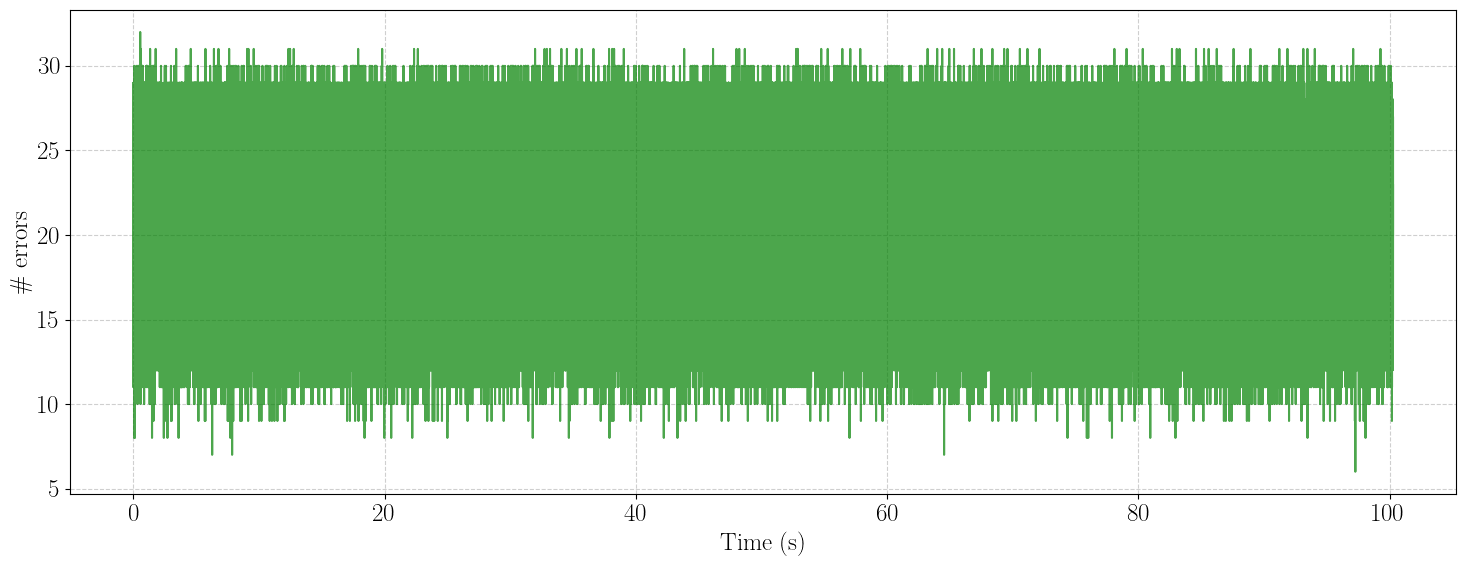

In [52]:
plt.figure(figsize=(15,6))
plt.plot(times, total_errors, '-', color = 'green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 20.858424198034974
Threshold (4σ): 26.5028
threshold: 26.50278241833017


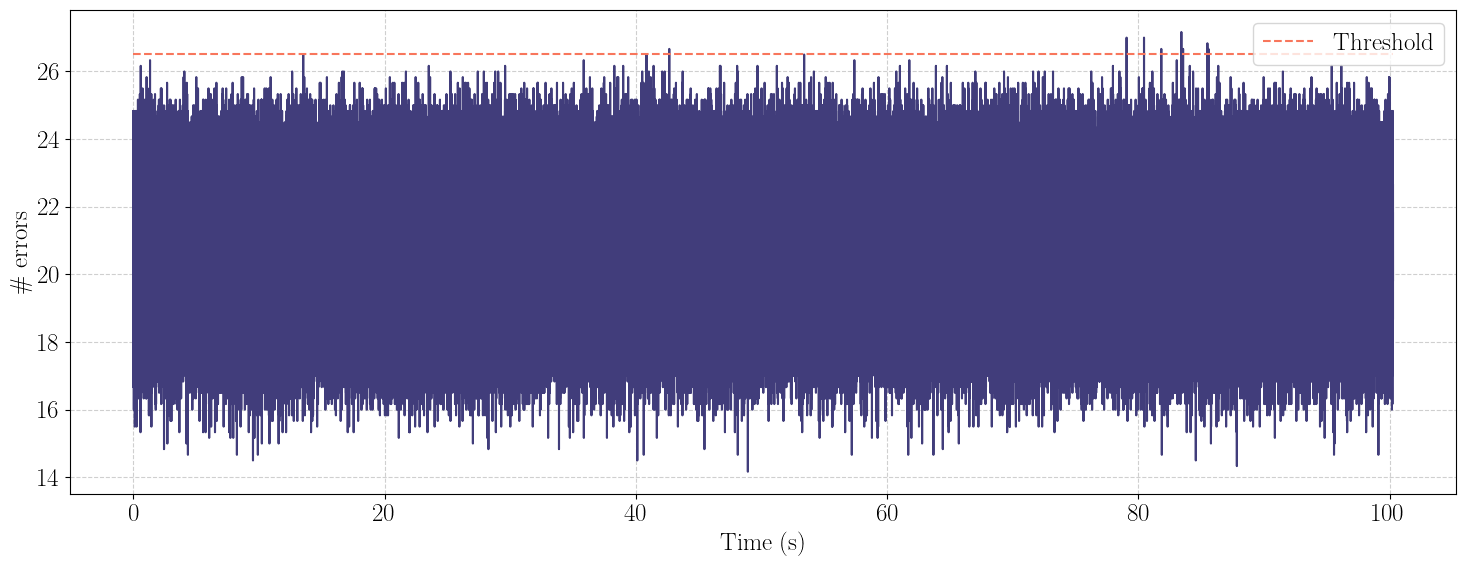

In [53]:
# Example: group every 6 points
bin_size = 6

# convert to arrays
times = np.array(times)
total_errors = np.array(total_errors)

# number of full bins
n_bins = len(total_errors) // bin_size

# reshape and take mean
binned_times = times[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

baseline = np.mean(binned_errors)  # or np.median(binned_errors)
print('mean number of errors:', baseline)

variance = np.var(binned_errors, ddof=1)  # sample variance
std_dev = np.sqrt(variance)

# optionally clip negatives to zero (if you only care about positive peaks)
#signal = np.clip(signal, 0, None)
threshold = 1.75 + baseline
k = 4
threshold = baseline + k * std_dev
print(f"Threshold ({k}σ): {threshold:.4f}")
print('threshold:', threshold)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color=color_1,)
plt.hlines(threshold, xmin=binned_times[0], xmax=binned_times[-1], color=color_magma_4, linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_times_low_good.pdf", format='pdf')
plt.show()

mean number of errors: 20.858424198034974


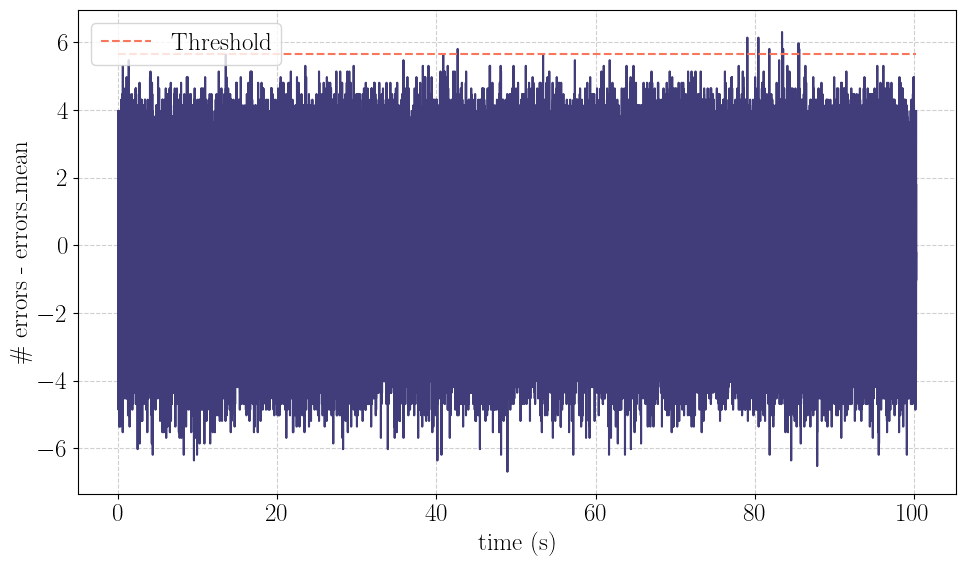

In [54]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline
print('mean number of errors:', baseline)

# optionally clip negatives to zero (if you only care about positive peaks)
threshold_subs = threshold - baseline

# ---------------- PLOT ----------------
plt.figure(figsize=(10,6))
plt.plot(binned_times, signal, '-', color=color_1,)
plt.hlines(threshold_subs, xmin=binned_times[0], xmax=binned_times[-1], color=color_magma_4, linestyle='--', label='Threshold')
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
if output_graphs:  
    plt.savefig("error_times_low.pdf", format='pdf')
plt.show()

In [55]:
# ---------------- PARAMETERS ----------------
threshold = threshold_subs
window_before = 0.001  # seconds
window_after  = 0.003  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

peaks_t = []

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    print(f"Peak at t = {t_peak:.3f} s")
    peaks_t.append(t_peak)
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times >= t_min) & (times <= t_max)
    
    # plot raw errors around peak
    # plt.figure(figsize=(10,4))
    # plt.plot(times[mask], total_errors[mask], 'o-', color='purple')
    # plt.axhline(np.mean(total_errors), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    # plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    # plt.xlabel("Time (s)")
    # plt.ylabel(r"\# errors (raw)")
    # plt.title(f"Raw errors around peak at t = {t_peak:.3f} s")
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.show()


Found 8 candidate peaks
Peak at t = 42.664 s
Peak at t = 79.064 s
Peak at t = 80.451 s
Peak at t = 81.827 s
Peak at t = 83.424 s
Peak at t = 83.561 s
Peak at t = 85.497 s
Peak at t = 85.580 s


In [56]:
print(peaks_t)

[np.float64(42.66377), np.float64(79.06397000000001), np.float64(80.45117), np.float64(81.82673000000001), np.float64(83.42405000000001), np.float64(83.56133000000001), np.float64(85.49657), np.float64(85.58033)]


True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 95378296
Number of false errors 9195476


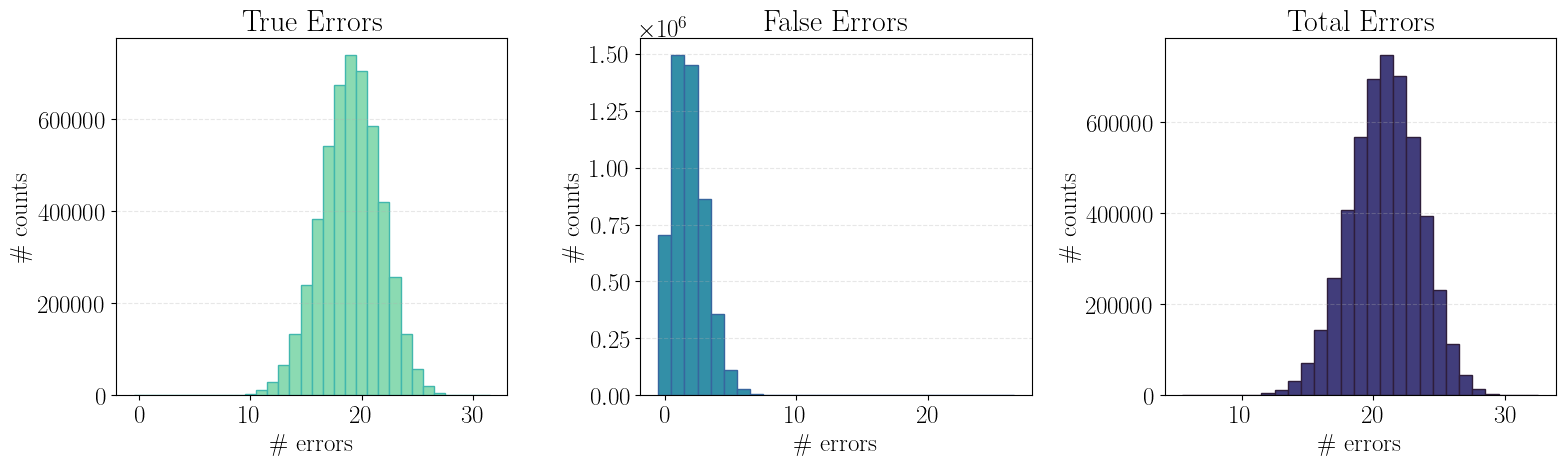

In [57]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors))
print('Number of false errors', sum(false_errors))

plt.figure(figsize=(16, 5))

    # Histograma de True Errors
plt.subplot(1, 3, 1)
plt.hist(true_errors, bins=range(max(true_errors)+2), edgecolor=color_4, align='left', color=color_5)
plt.title("True Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Histograma de False Errors
plt.subplot(1, 3, 2)
plt.hist(false_errors, bins=range(max(false_errors)+2), edgecolor=color_2, align='left', color=color_3)
plt.title("False Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")

plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.subplot(1,3,3)
plt.hist(total_errors, bins=range(min(total_errors), max(total_errors) + 2), color=color_1,align='left', edgecolor=color_0)
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.title("Total Errors")
#plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
#plt.show()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_histograms_low.pdf", format='pdf')
plt.show()

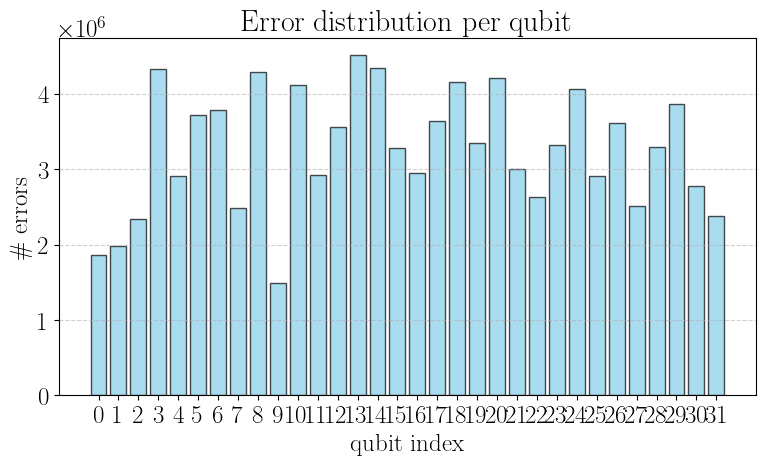

In [58]:
errors_per_qubit = errors_dict["low_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel(r"\# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## **Possible cosmic ray impact ?**

In [59]:
# center index

times = [np.float64(42.66377), np.float64(79.06397000000001), np.float64(80.45117), 
 np.float64(81.82673000000001), np.float64(83.42405000000001), np.float64(83.56133000000001), 
 np.float64(85.49657), np.float64(85.58033)]
index = 6
t_center = times[index]

errors_obj_sel = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=0, 
                               center_time=t_center, window=(-0.002, 0.002))
error_vis_sel = ErrorVisualizer(errors_obj_sel)

In [60]:
errors_dict_sel = errors_obj_sel.get_errors()

states_sel = errors_dict_sel["low_period_errors"]["states"]
total_errors_sel = np.array(errors_dict_sel['low_period_errors']['total_errors'])
times_sel = errors_dict_sel['low_period_errors']['times']

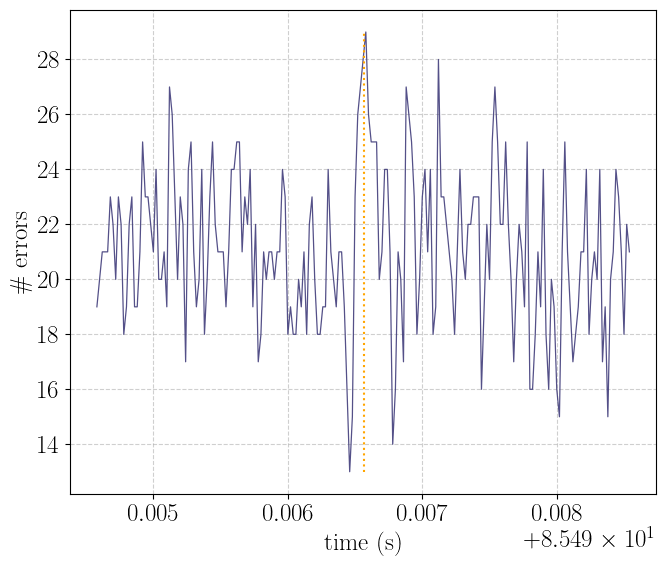

In [61]:
plt.figure(figsize=(7,6))

plt.plot(times_sel, total_errors_sel, '-', color = color_1, linewidth=0.9, alpha=0.9)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.vlines(t_center, ymin = total_errors_sel.min(), ymax=total_errors_sel.max(), color='orange', linestyle=':', label="peak")
plt.tight_layout()
#plt.savefig("cr_low_"+str(index)+".pdf", format='pdf')
plt.show()

Selected measurements: 200


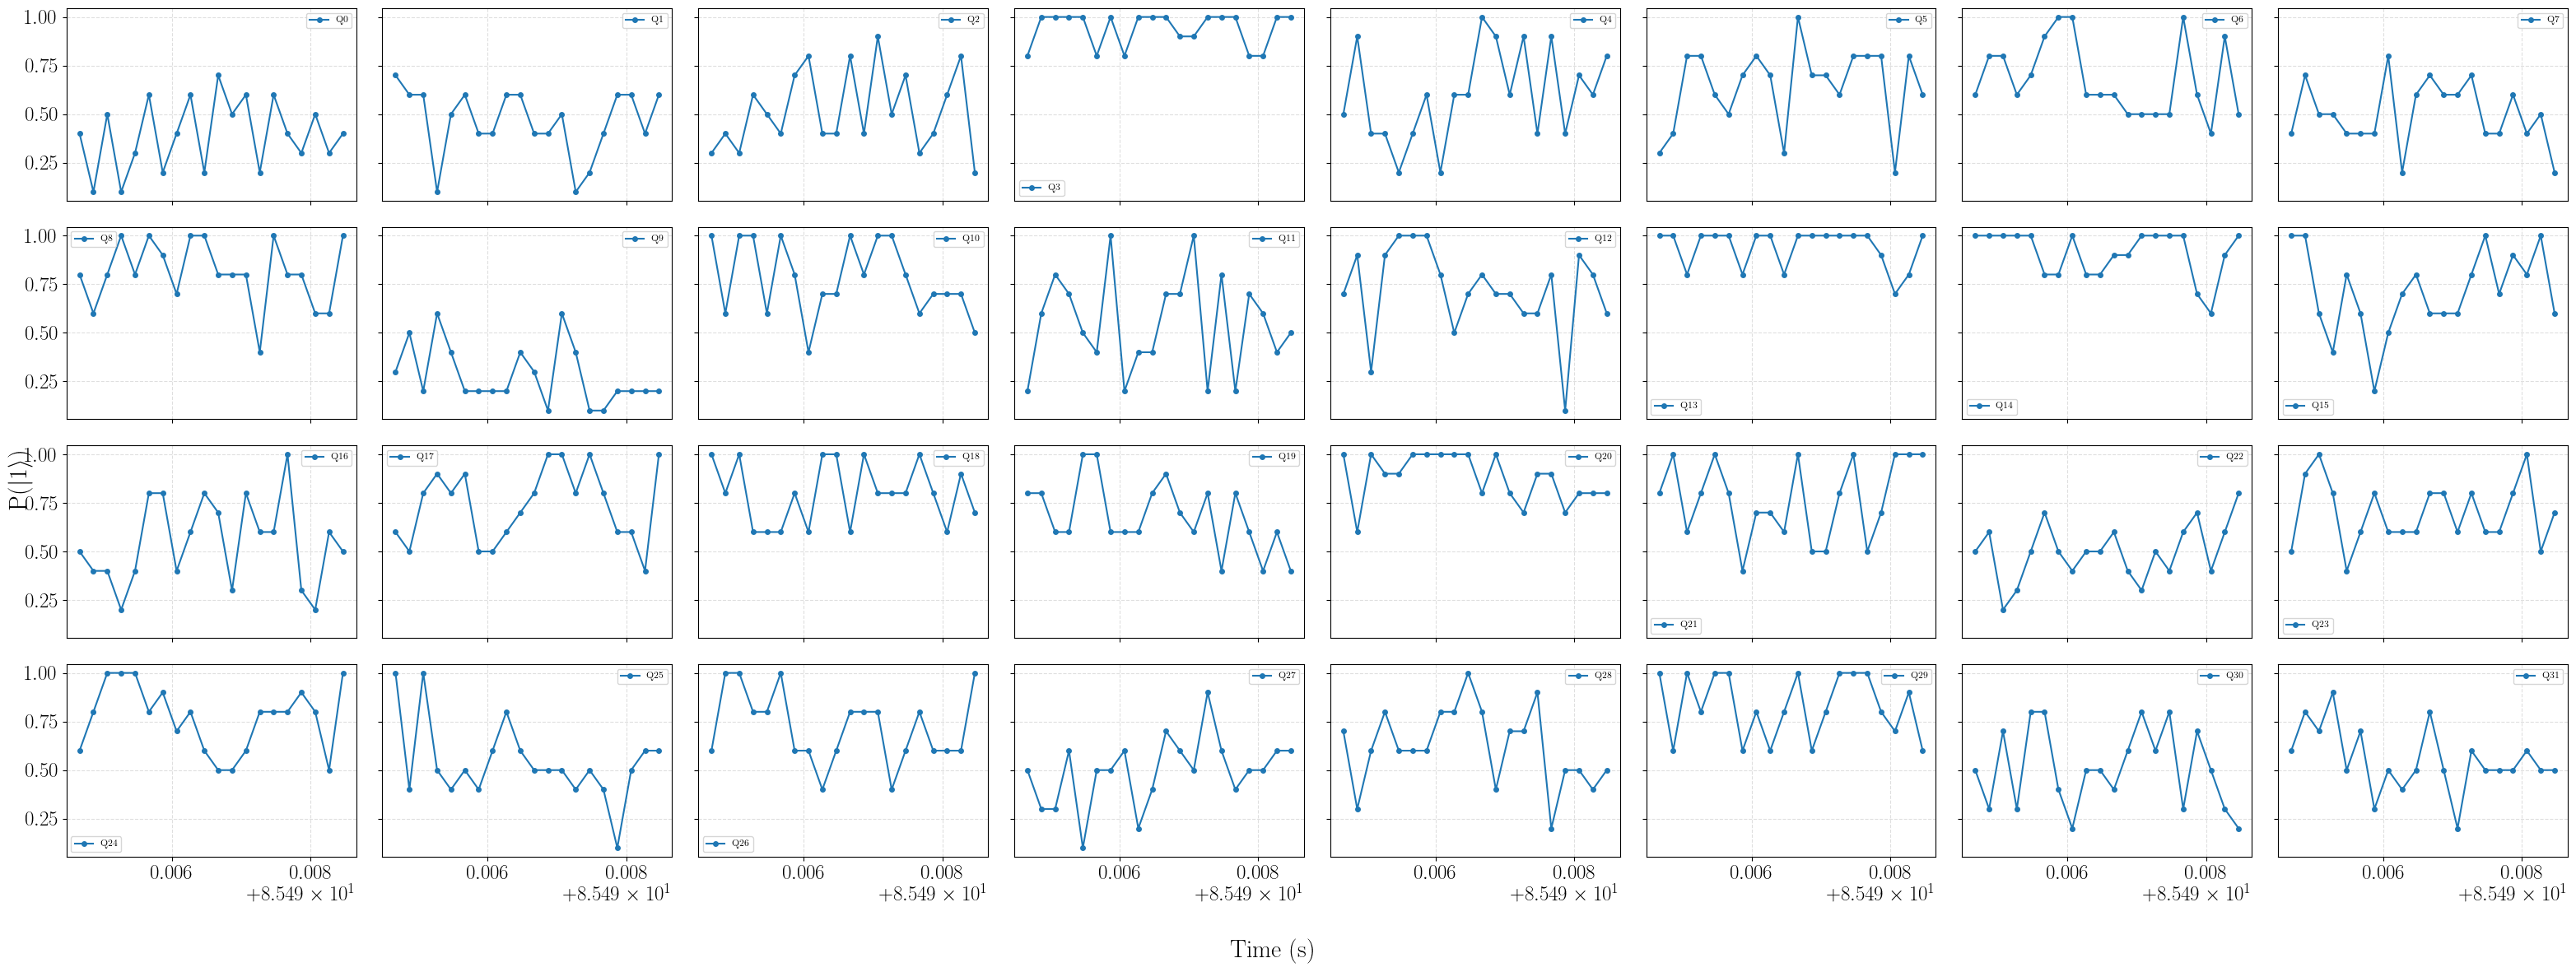

In [62]:
center = times[index]
# choose window and bin_size as needed
window=(-0.002, 0.002)
bin_size = 10



# Option A: get all qubits in one call (returns times_bin, p_qubits_bin (n_bins, n_qubits))
times_bin, p_qubits_bin = errors_obj.get_qubit_error_probabilities(center_time=center,
                                                                  window=window,
                                                                  bin_size=bin_size,
                                                                  qubit=None)

# If user called single-qubit version it may return 1D -> make 2D
if p_qubits_bin.ndim == 1:
    p_qubits_bin = p_qubits_bin[:, None]

n_qubits = p_qubits_bin.shape[1]

# layout
cols = 8
rows = int(np.ceil(n_qubits / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for q in range(n_qubits):
    ax = axes[q]
    p_q = p_qubits_bin[:, q]
    # valid points
    mask = np.isfinite(p_q)
    if mask.sum() == 0:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        continue

    t = times_bin[mask]
    y = p_q[mask]

    # plotting data points
    ax.plot(t, y, "o-", markersize=4, label=f"Q{q}")

    # fit only if enough points
    if len(t) >= 3:
        try:
            # model: A*exp(-(t-center)/tau) + B, fit over t (use shift to keep tau positive)
            def model(t, A, tau, B):
                return A * np.exp(-(t - center) / tau) + B

            # p0 = [max(y) - min(y), 0.005, min(y)]
            # popt, _ = curve_fit(model, t, y, p0=p0, maxfev=20000)
            # A, tau, B = popt
            # label = r"$\tau={:.1f}\ \mathrm{{ms}}$".format(tau*1000)
            # ax.plot(t_fit, model(t_fit, *popt), "r-", linewidth=1.5, label=label)
        except Exception:
            pass

    ax.legend(fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.4)

# hide unused axes
for a in axes[n_qubits:]:
    a.set_visible(False)

fig.supylabel(r"P($|1\rangle$)")
fig.supxlabel("Time (s)")
plt.tight_layout()
plt.show()
